In [1]:
import pandas as pd
import os
import mysql.connector

In [2]:
# List of CSV files and their corresponding table names.
csv_files = [
    ('customers.csv','customer'),
    ('geolocation.csv','geolocation'),
    ('order_items.csv','order_items'),
    ('orders.csv','orders'),
    ('payments.csv','payments'),
    ('products.csv','products'),
    ('sellers.csv','sellers')
   
]
#connect to MySql database

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Universe@123',
    database='ecommerce'
)

cursor = conn.cursor()

# Add folder that cobntains csv files.

folder_path = "C:/Users/kavit/OneDrive/Desktop/case Study/TargetEommerce";

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()






Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered

In [1]:
#import libraries 

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host='localhost',
                             username='root',
                             password='Universe@123',
                             database="ecommerce"
                            )
cur = db.cursor()

# List all unique cities where customers are located.






In [34]:
query = '''SELECT DISTINCT customer_city FROM customer'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.


In [12]:
query  = '''SELECT COUNT(order_id) , YEAR(order_purchase_timestamp) as order_placed_2017
 FROM ecommerce.orders
 WHERE YEAR(order_purchase_timestamp) = 2017;'''
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are ", data[0][0]
    

('total orders placed in 2017 are ', 45101)

# Find the total sales per category.

In [18]:
query = '''SELECT products.product_category as ProductCategory , SUM(payments.payment_value) as total_sales 
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category;

'''
cur.execute(query)
data = cur.fetchall()
"total sales per category: " , data;
df = pd.DataFrame(data, columns = ['Category','Sales'])
df

,Category,Sales
0,perfumery,5.067387e+05
1,Furniture Decoration,1.430176e+06
2,telephony,4.868821e+05
3,Fashion Bags and Accessories,2.181583e+05
4,bed table bath,1.712554e+06
...,...,...
69,cds music dvds,1.199430e+03
70,La Cuisine,2.913530e+03
71,Fashion Children's Clothing,7.856700e+02
72,PC Gamer,2.174430e+03


# Calculate the percentage of orders that were paid in installments.


In [4]:
query = '''SELECT 
    (SUM(CASE
        WHEN payment_installments > 1 THEN 1
        ELSE 0
    END)) / COUNT(*) * 100 As tage_orders_installemnts
FROM
    payments;'''
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments.",data[0][0]

('the percentage of orders that were paid in installments.',
 Decimal('49.4176'))

# Count the number of customers from each state.

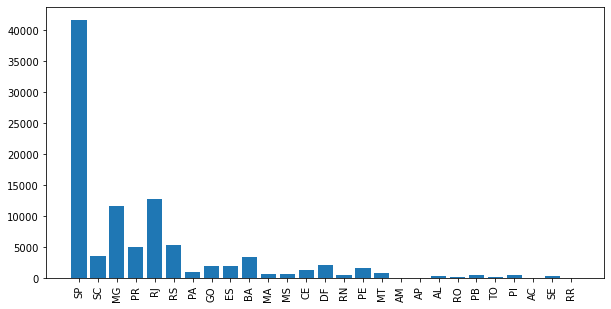

In [33]:
query = '''SELECT customer_state , COUNT(customer_id) as number_of_customers
FROM customer 
GROUP BY customer_state;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['State','Customer_Count'])

plt.figure(figsize=(10,5))               
plt.bar(df['State'],df['Customer_Count'])
plt.xticks(rotation = 90)

plt.show()

# Calculate the number of orders per month  in 2018

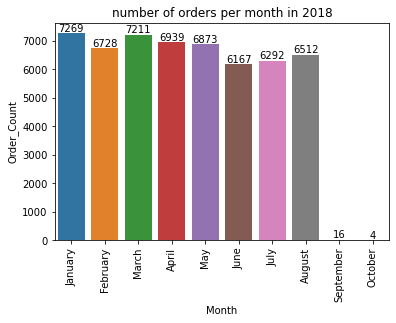

In [17]:
query='''SELECT count(order_id) AS Total_Orders, MONTHNAME(order_purchase_timestamp) AS Month_Number
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTH(order_purchase_timestamp) ;
'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Order_Count','Month'])
Month_Order = ["January","February",'March','April','May','June','July','August','September','October']

ax = sns.barplot(x = df['Month'] , y= df['Order_Count'], data=df, order= Month_Order)
plt.xticks(rotation=90)
# plt.xlabel("Months")
# plt.ylabel("Order_Count")
plt.title("number of orders per month in 2018")
ax.bar_label(ax.containers[0])
plt.show()





# find the average number of products per order, grouped by customer city.

In [7]:


query = '''WITH count_per_order as
(SELECT orders.order_id, orders.customer_id,COUNT(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customer.customer_city, round(avg(count_per_order.oc),2) average_orders
from customer join count_per_order
on customer.customer_id = count_per_order.customer_id
group by customer.customer_city;'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Customer_City','Average'])
df.head()


,Customer_City,Average
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15


# Calculate the percentage of total revenue contributed by each product categroy.

In [10]:
query = '''SELECT upper(products.product_category) category,
round((SUM(payment_value) / (select sum(payment_value) from payments))*100,2) as total_revenue_Percentage
from order_items JOIN 
products ON
order_items.product_id = products.product_id
JOIN 
payments 
ON 
payments.order_id = order_items.order_id
GROUP BY product_category 
ORDER BY total_revenue_Percentage desc;'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Category','Total Revenue Percentage'])
df

,Category,Total Revenue Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# . Identify the correlation between product price and the number of times a product has been purchased.

In [4]:
query='''SELECT  products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;'''


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Product_Category','Order_Count','Avg_Price'])
df

,Product_Category,Order_Count,Avg_Price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
...,...,...,...
69,flowers,33,33.64
70,Kitchen portable and food coach,15,264.57
71,House Comfort 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


In [7]:
# to find the corelation
import numpy as np
arr1 = df['Order_Count']
arr2 = df['Avg_Price']
a = np.corrcoef([arr1,arr2])
print(" the corellation between order count and price",a[0][1])

 the corellation between order count and price -0.10631514167157562


In [ ]:
# Conclusion 
#  this code calculates and prints the correlation between the number of orders and the average price.
#     If the correlation value is close to 1, it means they are strongly positively related; 
#     if it’s close to -1, they are strongly negatively related; if it’s around 0, there is little to no relationship.

# 1. Calculate the moving average of order values for each customer over their order history.

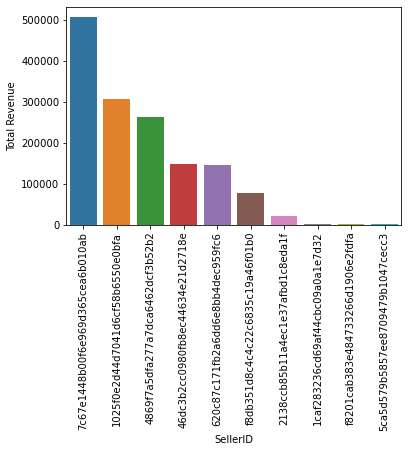

In [21]:
query = '''
Select * , dense_rank() over(order by revenue desc) as ranking from(
SELECT order_items.seller_id , SUM(payments.payment_value) Revenue

FROM order_items join payments
ON order_items.order_id = payments.order_id
GROUP BY seller_id
LIMIT 10) as a '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['SellerID','Total Revenue','Rankings'])
df.head(5)
sns.barplot(x = 'SellerID', y = 'Total Revenue', data = df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.


In [19]:
query='''select customer_id, order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from(
SELECT orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders 
on payments.order_id = orders.order_id
LIMIT 5
) as a;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Customer_id','Order_time','Payment','Moving Average'])
df


,Customer_id,Order_time,Payment,Moving Average
0,0080e98d82eceee143dc006defe00687,2017-10-26 18:29:04,72.66,72.660004
1,4a00f00d951c167739888a1f16c56e8e,2018-01-14 18:49:14,48.91,48.910000
2,625784c6aad212dc7d249ea10e276617,2017-07-18 13:32:25,154.14,154.139999
3,7e2ca73af071679902a9ba14d7c3cee8,2018-06-11 14:59:24,340.08,340.079987
4,cefab390926b6fc3de3ca94c82ebb1ba,2017-09-25 16:38:46,26.58,26.580000
